Original dataset size: 432, Augmented dataset size: 864
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - kl_loss: 0.0330 - loss: 2836.0957 - reconstruction_loss: 2836.0630 - val_kl_loss: 0.0831 - val_loss: 2823.4414 - val_reconstruction_loss: 2823.3584
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - kl_loss: 0.4456 - loss: 2815.8171 - reconstruction_loss: 2815.3713 - val_kl_loss: 5.0261 - val_loss: 2775.1487 - val_reconstruction_loss: 2770.1226
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - kl_loss: 6.3576 - loss: 2764.5610 - reconstruction_loss: 2758.2034 - val_kl_loss: 1.2520 - val_loss: 2728.9639 - val_reconstruction_loss: 2727.7119
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - kl_loss: 0.8985 - loss: 2734.4451 - reconstruction_loss: 2733.5466 - val_kl_loss: 1.2227 - val_loss: 2725.9351 - val_reconstruction_loss: 2724.7124
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - kl_loss: 2.1127 - loss: 2729.8296 - reconstruction_loss: 2727.7168 - val_kl_

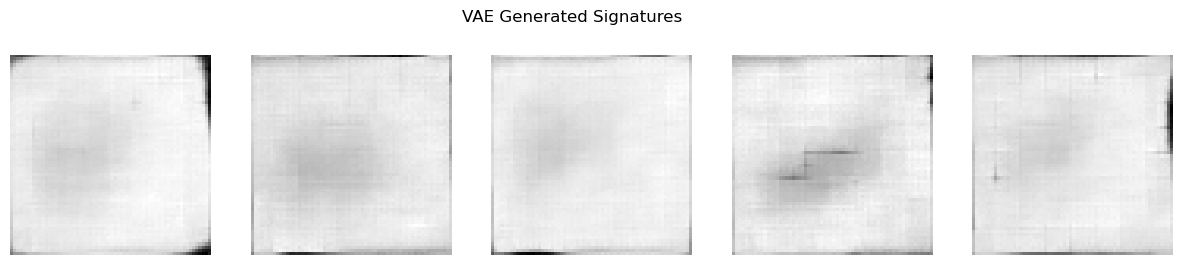

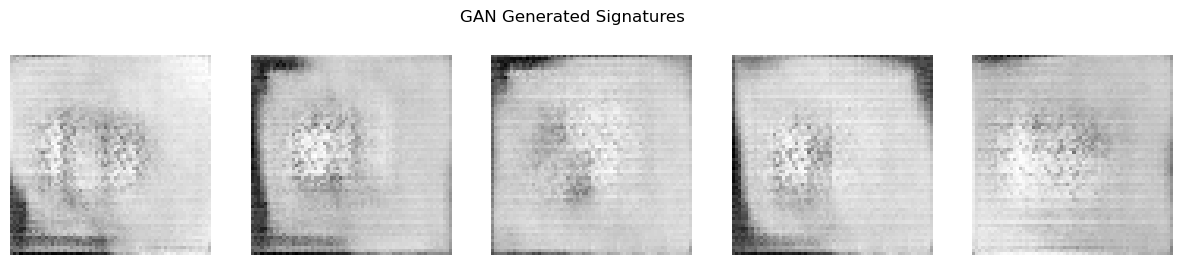

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


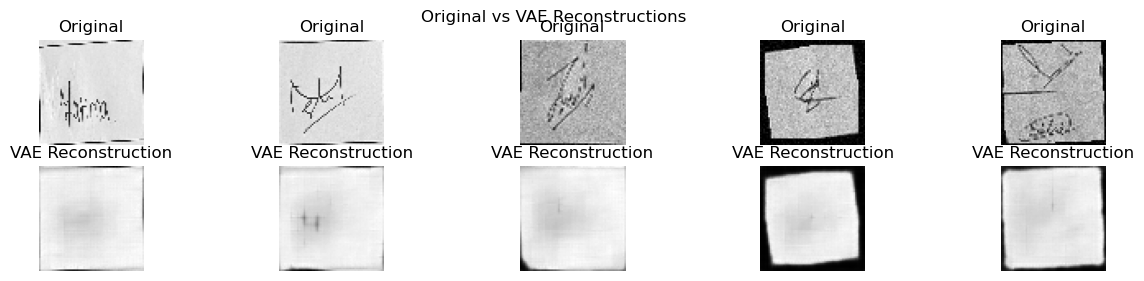

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Test Reconstruction Loss: 0.012726878747344017


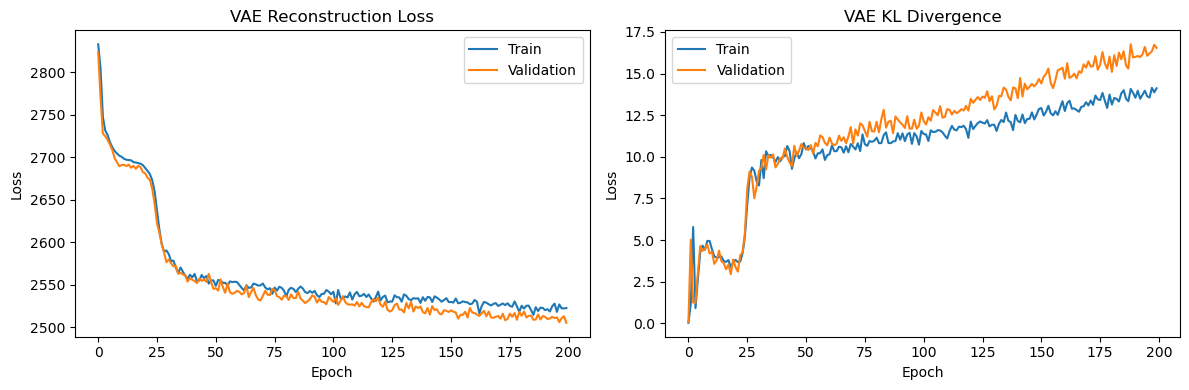

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Wrapper
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data loading and preprocessing
def load_and_preprocess_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
    return np.array(images)

def process_all_folders(root_path):
    all_images = []
    for folder_name in os.listdir(root_path):
        if folder_name.startswith('student_'):
            folder_path = os.path.join(root_path, folder_name)
            if os.path.isdir(folder_path):
                images = load_and_preprocess_images(folder_path)
                all_images.extend(images)
    return np.array(all_images)

# Data augmentation
def augment_image(image):
    # Random rotation
    angle = np.random.uniform(-15, 15)
    rotated = rotate(image, angle, reshape=False)
    
    # Random scaling
    scale = np.random.uniform(0.8, 1.2)
    scaled = zoom(rotated, (scale, scale, 1))
    
    # Ensure the image is at least 64x64
    h, w = scaled.shape[:2]
    if h < 64 or w < 64:
        pad_h = max(64 - h, 0)
        pad_w = max(64 - w, 0)
        scaled = np.pad(scaled, ((pad_h//2, pad_h - pad_h//2), (pad_w//2, pad_w - pad_w//2), (0, 0)), mode='constant')
    
    # Random cropping to maintain original size
    h, w = scaled.shape[:2]
    top = np.random.randint(0, h - 63)
    left = np.random.randint(0, w - 63)
    cropped = scaled[top:top+64, left:left+64]
    
    # Add random noise
    noise = np.random.normal(0, 0.05, (64, 64, 1))
    augmented = np.clip(cropped + noise, 0, 1)
    
    return augmented

def augment_dataset(images, augmentation_factor=2):
    augmented_images = []
    for image in images:
        augmented_images.append(image)
        for _ in range(augmentation_factor - 1):
            augmented_images.append(augment_image(image))
    return np.array(augmented_images)

# VAE implementation
latent_dim = 64

# Encoder
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

def vae_loss(data, reconstruction, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    
    # Add a perceptual loss term (e.g., using a pre-trained VGG network)
    # This would require additional implementation
    
    total_loss = reconstruction_loss + kl_loss # + perceptual_loss
    return total_loss, reconstruction_loss, kl_loss

# Decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)


encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            total_loss, reconstruction_loss, kl_loss = vae_loss(data, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        total_loss, reconstruction_loss, kl_loss = vae_loss(data, reconstruction, z_mean, z_log_var)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
class SpectralNormalization(Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name='sn_u',
            dtype=tf.float32)

    def call(self, inputs, training=None):
        self._compute_weights(training)
        output = self.layer(inputs)
        return output

    def _compute_weights(self, training):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u_hat = self.u
        v_hat = None

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)
                
                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        w_norm = self.w / sigma

        # Tensorflow Keras Layers does not allow us to modify the kernel directly
        # We use the `kernel` property to set the weight
        self.layer.kernel.assign(w_norm)

        self.u.assign(u_hat)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

# GAN implementation
def build_generator():
    model = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, 7, padding='same', activation='tanh')
    ])
    return model

def build_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(64, 64, 1)),
        SpectralNormalization(layers.Conv2D(64, 4, strides=2, padding='same')),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        SpectralNormalization(layers.Conv2D(128, 4, strides=2, padding='same')),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        SpectralNormalization(layers.Conv2D(256, 4, strides=2, padding='same')),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        SpectralNormalization(layers.Dense(1))
    ])
    return model
    
generator = build_generator()
discriminator = build_discriminator()

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)

@tf.function
def train_step_gan(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Visualization function
def visualize_signatures(signatures, title):
    fig, axes = plt.subplots(1, len(signatures), figsize=(15, 3))
    for i, sig in enumerate(signatures):
        axes[i].imshow(sig.reshape(64, 64), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Main execution
root_path = r'E:\GenAi'
all_images = process_all_folders(root_path)
all_images = all_images.reshape((-1, 64, 64, 1)).astype('float32') / 255.

# Augment the dataset
augmented_images = augment_dataset(all_images)
print(f"Original dataset size: {len(all_images)}, Augmented dataset size: {len(augmented_images)}")

# Split the data into train, validation, and test sets
train_images, test_images = train_test_split(augmented_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

# Prepare the datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)

# Train VAE
vae_history = vae.fit(train_dataset, epochs=200, validation_data=val_dataset)

# Train GAN
gan_epochs = 200
for epoch in range(gan_epochs):
    gen_losses = []
    disc_losses = []
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step_gan(image_batch)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
    
    print(f"GAN Epoch {epoch+1}, G Loss: {tf.reduce_mean(gen_losses):.4f}, D Loss: {tf.reduce_mean(disc_losses):.4f}")

# Evaluate models
vae_test_results = vae.evaluate(test_dataset)
print("VAE Test Results:", vae_test_results)

# Generate new signatures
def generate_signatures_vae(num_samples):
    z_sample = tf.random.normal(shape=(num_samples, latent_dim))
    return vae.decoder.predict(z_sample)

def generate_signatures_gan(num_samples):
    noise = tf.random.normal([num_samples, latent_dim])
    return generator.predict(noise)

generated_signatures_vae = generate_signatures_vae(5)
generated_signatures_gan = generate_signatures_gan(5)

# Visualize results
visualize_signatures(generated_signatures_vae, "VAE Generated Signatures")
visualize_signatures(generated_signatures_gan, "GAN Generated Signatures")

# Compare generated images with original images
original_samples = test_images[:5]
vae_reconstructions = vae.predict(original_samples)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(original_samples[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title('Original')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(vae_reconstructions[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
    plt.title('VAE Reconstruction')

plt.suptitle("Original vs VAE Reconstructions")
plt.show()

# Calculate reconstruction loss for test set
test_reconstructions = vae.predict(test_images)
mse = tf.keras.losses.MeanSquaredError()
test_reconstruction_loss = mse(test_images, test_reconstructions).numpy()
print(f"Test Reconstruction Loss: {test_reconstruction_loss}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vae_history.history['reconstruction_loss'], label='Train')
plt.plot(vae_history.history['val_reconstruction_loss'], label='Validation')
plt.title('VAE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vae_history.history['kl_loss'], label='Train')
plt.plot(vae_history.history['val_kl_loss'], label='Validation')
plt.title('VAE KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()